In [1]:
!pip install haralyzer

In [2]:
import json
from haralyzer import HarParser, HarPage

In [3]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from datetime import datetime
from datetime import timedelta

In [5]:
with open('about.gitlab.com.har', 'r') as f:
    har_parser = HarParser(json.loads(f.read()))

In [6]:
data = har_parser.har_data
type(data)

dict

In [7]:
data.keys()

dict_keys(['version', 'creator', 'pages', 'entries'])

In [8]:
har_parser.har_data["pages"]

[{'startedDateTime': '2023-09-14T21:45:19.920Z',
  'id': 'page_3',
  'title': 'https://about.gitlab.com/',
  'pageTimings': {'onContentLoad': 628.8660000136588,
   'onLoad': 3286.5790000068955}}]

In [9]:
with open('about.gitlab.com.har', 'r') as f:
    har_page = HarPage('page_3', har_data=json.loads(f.read()))

In [10]:
har_page.page_size

206786

In [11]:
# transfered data size in KB
print("page size", har_page.page_size_trans/1000)
print("images", har_page.image_size_trans/1000)
print("CSS", har_page.css_size_trans/1000)
print("text", har_page.text_size_trans/1000)
print("JS", har_page.js_size_trans/1000)

page size 5591.55
images 1242.718
CSS 132.322
text 573.022
JS 2201.863


In [12]:
# Extract entries from HAR data
entries = har_parser.har_data['entries']

# Create an empty list to store data
data = []

# Loop through each entry
for entry in entries:
    url = entry['request']['url']
    method = entry['request']['method']
    status = entry['response']['status']
    content_type = entry['response']['content'].get('mimeType', 'N/A')
    time = entry['time']
    size = entry['response']['bodySize']
    start_time = entry['startedDateTime']
    start_time_datetime = datetime.fromisoformat(start_time.replace('Z', '+00:00'))
    end_time = start_time_datetime + timedelta(milliseconds=time)
    
    data.append({
        'URL': url,
        'Method': method,
        'Status': status,
        'Content-Type': content_type,
        'Time (ms)': time,
        'Size (Bytes)': size,
        'Start Time': start_time_datetime,
        'End Time': end_time
    })

# Create a Pandas DataFrame
df = pd.DataFrame(data)

In [13]:
df.describe()

Status     Time (ms)   Size (Bytes)
count  182.000000    182.000000     182.000000
mean   200.137363    191.076489    6211.164835
std     21.164649   1187.133893   25320.024980
min      0.000000      8.204000    -293.000000
25%    200.000000     42.262500      -1.000000
50%    200.000000     77.428000      -1.000000
75%    200.000000    128.182250      -1.000000
max    302.000000  16075.987000  157131.000000

In [14]:
df.head() 

URL Method  Status  \
0                        https://about.gitlab.com/    GET     200   
1  https://about.gitlab.com/_nuxt/image/457e30.svg    GET     200   
2  https://about.gitlab.com/_nuxt/image/d138fa.png    GET     200   
3  https://about.gitlab.com/_nuxt/image/64a83d.png    GET     200   
4  https://about.gitlab.com/_nuxt/image/1aa72a.png    GET     200   

    Content-Type  Time (ms)  Size (Bytes)                       Start Time  \
0      text/html     54.508            -1 2023-09-14 21:45:19.919000+00:00   
1  image/svg+xml     53.479            -1 2023-09-14 21:45:20.058000+00:00   
2      image/png     52.376            -1 2023-09-14 21:45:20.059000+00:00   
3      image/png    108.434            -1 2023-09-14 21:45:20.059000+00:00   
4      image/png    162.989            -1 2023-09-14 21:45:20.059000+00:00   

                          End Time  
0 2023-09-14 21:45:19.973508+00:00  
1 2023-09-14 21:45:20.111479+00:00  
2 2023-09-14 21:45:20.111376+00:00  
3 2023-09-14 21:45:20.167434+00:00  
4 2023-09-14 21:45:20.221989+00:00

In [15]:
# remove 0B and negative values

df = df[df['Size (Bytes)'] > 0 ]
df.describe()

Status  Time (ms)  Size (Bytes)
count    25.0   25.00000      25.00000
mean    200.0  192.51752   45245.84000
std       0.0  154.67329   54727.07078
min     200.0   26.50700       2.00000
25%     200.0   44.94700    2167.00000
50%     200.0  156.43000   17171.00000
75%     200.0  335.83800   54246.00000
max     200.0  473.56600  157131.00000

In [16]:
df.groupby('Content-Type').sum()

Status  Time (ms)  Size (Bytes)
Content-Type                                             
application/json             200     38.252          4258
application/x-javascript     600     95.558          3341
image/gif                    200     57.826            43
image/png                   2600   3697.295        923782
text/css                     400     65.178         67966
text/html                    400    471.437         19338
text/javascript              400    226.241        112416
text/plain                   200    161.151             2

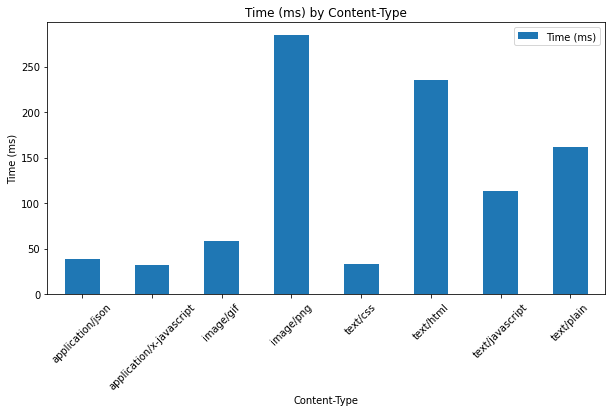

In [17]:
df = df.groupby('Content-Type').agg({'Status': 'first', 'Time (ms)': 'mean', 'Size (Bytes)': 'mean'})

# Plotting Time (ms) by Content-Type
df['Time (ms)'].plot(kind='bar', figsize=(10, 5), legend=True)
plt.title('Time (ms) by Content-Type')
plt.ylabel('Time (ms)')
plt.xlabel('Content-Type')
plt.xticks(rotation=45)
plt.show()

# Plotting Size (Bytes) by Content-Type
df['Size (Bytes)'].plot(kind='bar', figsize=(10, 5), legend=True, color='orange')
plt.title('Size (Bytes) by Content-Type')
plt.ylabel('Size (Bytes)')
plt.xlabel('Content-Type')
plt.xticks(rotation=45)
plt.show()

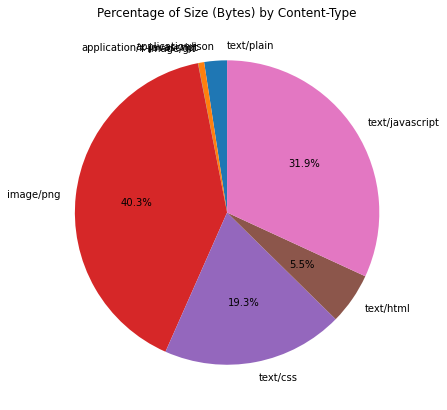

In [23]:
# Plotting Time (ms) as a pie chart
plt.figure(figsize=(10, 7), facecolor='white')
ax1 = plt.gca()
ax1.set_facecolor('white')
plt.pie(df['Time (ms)'], labels=df.index, autopct=lambda pct: "{:.1f}%".format(pct) if pct >= 2.5 else '')
plt.title('Percentage of Time (ms) by Content-Type')
plt.show()

# Plotting Size (Bytes) as a pie chart
plt.figure(figsize=(10, 7), facecolor='white')
ax2 = plt.gca()
ax2.set_facecolor('white')
plt.pie(df['Size (Bytes)'], labels=df.index, autopct=lambda pct: "{:.1f}%".format(pct) if pct >= 2.5 else '', startangle=90)
plt.title('Percentage of Size (Bytes) by Content-Type')
plt.show()